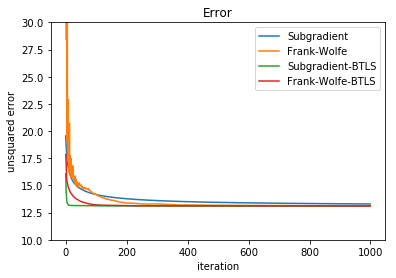

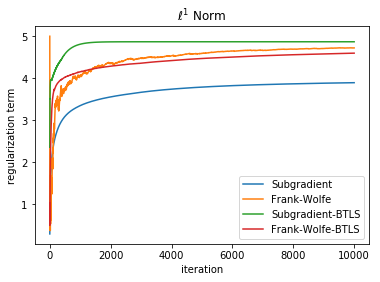

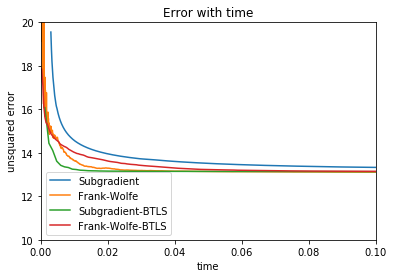

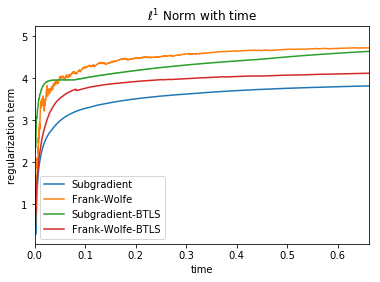

In [1]:
import numpy as np
import numpy.random as rn
import numpy.linalg as la
import matplotlib.pyplot as plt
from __future__ import division
from time import *


def frank_wolfe(x, A, b, t, gam):
    grad=np.dot(A.T,np.dot(A,x)-b)
    idx=np.argmax(np.abs(grad))
    s=np.zeros(A.shape[1])
    s[idx]=-gam * np.sign(grad[idx])
    eta=2/(t+2)    
    x=x+eta*(s-x)
    return x


def subgradient(x, A, b, t, lam, c=1e-4):
    grad_l1=np.sign(x)
    grad_l1[np.where(x==0)]=np.random.rand()*2-1
    grad=np.dot(A.T,np.dot(A,x)-b)+lam*grad_l1
    eta=c/np.sqrt(t+1)
    y=x-eta*grad
    # to return the best solution
    if (0.5*np.square(la.norm(np.dot(A,y)-b,2))+lam*np.sum(abs(y))) < (0.5*np.square(la.norm(np.dot(A,x)-b,2))+lam*np.sum(abs(x))):
        x=y
    return x

def subgradient_btls(x, A, b, t, lam):
    grad_l1=np.sign(x)
    grad_l1[np.where(x==0)]=np.random.rand()*2-1
    grad=np.dot(A.T,np.dot(A,x)-b)+lam*grad_l1
    alpha,beta=0.1, 0.7
    stepsize=1
    while ( (0.5*np.square(la.norm(np.dot(A,x-stepsize*grad)-b))+lam*np.sum(abs(x-stepsize*grad))) 
           > (0.5*np.square(la.norm(np.dot(A,x)-b))+lam*np.sum(abs(x)) - alpha*stepsize*np.square(la.norm(grad))) ) :
        stepsize=beta*stepsize
    y=x-stepsize*grad
    # to return the best solution
    if (0.5*np.square(la.norm(np.dot(A,y)-b,2))+lam*np.sum(abs(y))) < (0.5*np.square(la.norm(np.dot(A,x)-b,2))+lam*np.sum(abs(x))):
        x=y
    return x

def frank_wolfe_btls(x, A, b, t, gam):
    grad=np.dot(A.T,np.dot(A,x)-b)
    idx=np.argmax(np.abs(grad))
    s=np.zeros(A.shape[1])
    s[idx]=-gam * np.sign(grad[idx])    
    alpha,beta=0.1, 0.7
    stepsize=1
    while ( (0.5*np.square(la.norm(np.dot(A,x+stepsize*(s-x))-b))) 
           > (0.5*np.square(la.norm(np.dot(A,x)-b))+ alpha*stepsize*np.dot(grad,s-x)) ):
        stepsize=beta*stepsize    
    x=x+stepsize*(s-x)
    return x

def descent(update, A, b, reg, T=int(1e3)):
    x = np.zeros(A.shape[1])
    error = []
    l1 = []
    loss = []
    elapsed_time = []
    start=time()
    y = x
    for t in xrange(T):
        x = update(x, A, b, t, reg)
        y = y + x
        end=time()
        if (t % 1 == 0) or (t == T - 1):
            error.append(la.norm(np.dot(A, x) - b))
            l1.append(np.sum(abs(x)))
            loss.append(0.5*la.norm(np.dot(A, x) - b)+reg*np.sum(abs(x)))
            elapsed_time.append(end-start)
            assert not np.isnan(error[-1])
    return x, error, l1, elapsed_time, loss


def main(T=int(1e4)):
    A = np.load("A.npy")
    b = np.load("b.npy")
    
    R, lam=5., 1e-4

    x_sg, error_sg, l1_sg, t_sg, loss_sg = descent(subgradient, A, b, reg=lam, T=T)
    x_fw, error_fw, l1_fw, t_fw, loss_fw = descent(frank_wolfe, A, b, reg=R, T=T)
    x_sg_btls, error_sg_btls, l1_sg_btls, t_sg_btls, loss_sg_btls = descent(subgradient_btls, A, b, reg=lam, T=T)
    x_fw_btls, error_fw_btls, l1_fw_btls, t_fw_btls, loss_fw_btls = descent(frank_wolfe_btls, A, b, reg=R, T=T)
    
    %matplotlib inline
    
    # x-axis is iteration
    fig=plt.figure()
    plt.plot(error_sg[:1000], label='Subgradient')
    plt.plot(error_fw[:1000], label='Frank-Wolfe')
    plt.plot(error_sg_btls[:1000], label='Subgradient-BTLS')
    plt.plot(error_fw_btls[:1000], label='Frank-Wolfe-BTLS')
    plt.title('Error')
    plt.xlabel('iteration')
    plt.ylabel('unsquared error')
    plt.ylim(10,30)
    plt.legend()
#     plt.savefig('error-iter-1e3.eps')
    plt.show()
    
    fig=plt.figure()
    plt.plot(l1_sg, label='Subgradient')
    plt.plot(l1_fw, label='Frank-Wolfe')
    plt.plot(l1_sg_btls, label='Subgradient-BTLS')
    plt.plot(l1_fw_btls, label='Frank-Wolfe-BTLS')
    plt.title("$\ell^1$ Norm")
    plt.xlabel('iteration')
    plt.ylabel('regularization term')
    plt.legend()
#     plt.savefig('l1-iter-1e4.eps')
    plt.show()
    
    # x-axis is time
    fig=plt.figure()
    plt.plot(t_sg, error_sg, label='Subgradient')
    plt.plot(t_fw, error_fw, label='Frank-Wolfe')
    plt.plot(t_sg_btls, error_sg_btls, label='Subgradient-BTLS')
    plt.plot(t_fw_btls, error_fw_btls, label='Frank-Wolfe-BTLS')
    plt.title('Error with time')
    plt.xlabel('time')
    plt.ylabel('unsquared error')
    plt.legend()
#     plt.xlim(0,min(t_sg[-1],t_fw[-1],t_sg_btls[-1],t_fw_btls[-1]))
    plt.xlim(0,0.1)
    plt.ylim(10,20)
#     plt.savefig('error-time.eps')
    plt.show()
    
    fig=plt.figure()
    plt.plot(t_sg, l1_sg, label='Subgradient')
    plt.plot(t_fw, l1_fw, label='Frank-Wolfe')
    plt.plot(t_sg_btls, l1_sg_btls, label='Subgradient-BTLS')
    plt.plot(t_fw_btls, l1_fw_btls, label='Frank-Wolfe-BTLS')
    plt.title("$\ell^1$ Norm with time")
    plt.xlabel('time')
    plt.ylabel('regularization term')
    plt.legend()
    plt.xlim(0,min(t_sg[-1],t_fw[-1],t_sg_btls[-1],t_fw_btls[-1]))
#     plt.savefig('l1-time.eps')
    plt.show()

if __name__ == "__main__":
    main()
